In [1]:
# Dependencies and setup
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import geopandas as gpd
import fiona

## Unemployment Data

In [2]:
# Import unemployment rate csv file, create DataFrame, and set index to Area Type
unemployment_data = Path('resources/Local_Area_Unemployment_Statistics__LAUS___Annual_Average.csv')
unemployment_df = pd.read_csv(unemployment_data)
unemployment_df = unemployment_df.set_index('Area Type')
unemployment_df

# Filter Area Type to only include County and State data and reduce columns
area_type_df = unemployment_df.loc[['State','County'],
                                   ['Area Name', 'Year', 'Labor Force', 'Employment', 'Unemployment','Unemployment Rate']]
area_type_df

# Filter Year to only include 2017-2022 and filter out California totals
recent_unemployment = area_type_df.loc[(area_type_df['Year'] > 2016) & 
                          (area_type_df['Area Name'] != 'California')]

# Rename Area Name column
recent_unemployment = recent_unemployment.rename(columns = {'Area Name': 'County'})

In [3]:
# Reduce Columns
recent_unemployment = recent_unemployment[['County', 'Year', 'Unemployment Rate']]
recent_unemployment.style.format({'Unemployment Rate': '{:,.2%}'})
recent_unemployment.head()

,County,Year,Unemployment Rate
Area Type,,,
County,Alameda County,2017,3.7
County,Alpine County,2017,6.2
County,Amador County,2017,5.0
County,Butte County,2017,5.8
County,Calaveras County,2017,4.8


## Homeless Count Data

In [4]:
# Import age csv file and create DataFrame
age_data = Path('resources/experiencing_homelessness_age_demographics.csv')
age_df = pd.read_csv(age_data)

In [5]:
# Create clean DataFrame by dropping rows with '*' in count column
clean_age_df = age_df.loc[age_df['EXPERIENCING_HOMELESSNESS_CNT']!='*']

In [6]:
# Find all Continuums of Care in Los Angeles County
la_county_coc = clean_age_df.loc[clean_age_df["COC_NAME"].str.contains("Los Angeles County", case = False)]

In [7]:
# Use replace to group all of the Los Angeles County CoCs
cocs_to_replace = ["Glendale CoC (Los Angeles County)",
                   "Pasadena CoC (Los Angeles County)", 
                   "Long Beach CoC (Los Angeles County)"
                  ]
clean_age_df['COC_NAME'] = clean_age_df['COC_NAME'].replace(cocs_to_replace, "Los Angeles County CoC")


C:\Users\mattcalvert\AppData\Local\Temp\ipykernel_28072\506125602.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_age_df['COC_NAME'] = clean_age_df['COC_NAME'].replace(cocs_to_replace, "Los Angeles County CoC")


In [8]:
# Change homeless count data type to integer
clean_age_df['EXPERIENCING_HOMELESSNESS_CNT'] = clean_age_df["EXPERIENCING_HOMELESSNESS_CNT"].astype(int)

# Group by year and COC Name and sum homeless counts
total_homeless_count = clean_age_df.groupby(['CALENDAR_YEAR', 'COC_NAME'])['EXPERIENCING_HOMELESSNESS_CNT'].sum().reset_index()

C:\Users\mattcalvert\AppData\Local\Temp\ipykernel_28072\4059735931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_age_df['EXPERIENCING_HOMELESSNESS_CNT'] = clean_age_df["EXPERIENCING_HOMELESSNESS_CNT"].astype(int)


In [9]:
# Rename CALENDAR_YEAR column
total_homeless_count = total_homeless_count.rename(columns = {'CALENDAR_YEAR': 'Year'})

## Population Data

In [10]:
# Import california population csv file and create DataFrame
population_data = Path('resources/california_population.csv')
population_df = pd.read_csv(population_data)
population_df.head()

,COUNTY,Year,Total Population,Total Housing Units,Single Detached,Single Attached,Two to Four,Five Plus,Mobile Homes,Occupied,Vacancy Rate,Persons per Household
0,Alameda,2017,"1,644,303","596,937","315,395","46,333","65,721","161,630","7,858","564,303",5.50%,2.84
1,Alpine,2017,"1,161","1,780","1,052",18,45,631,34,483,72.90%,2.35
2,Amador,2017,"36,900","18,189","14,905",570,605,690,"1,419","15,140",16.80%,2.18
3,Butte,2017,"225,468","98,871","61,689","3,112","8,976","10,855","14,239","90,791",8.20%,2.42
4,Calaveras,2017,"45,170","27,908","24,256",366,676,392,"2,218","18,371",34.20%,2.43


In [11]:
# Reduce columns to just county, year, and total population
population_df = population_df[['COUNTY','Year','Total Population']]

# Rename COUNTY column
population_df = population_df.rename(columns = {'COUNTY': 'County'})

#Filter out California
population_df = population_df.loc[population_df['County'] != 'California']

#add 'County' to the county names
population_df['County'] = population_df['County'] + ' County'

# Remove "," from Total Population
population_df['Total Population'] = population_df['Total Population'].str.replace(',','')

# Change Total Population data type to integer
population_df['Total Population'] = population_df['Total Population'].astype(int)
population_df.head()

,County,Year,Total Population
0,Alameda County,2017,1644303
1,Alpine County,2017,1161
2,Amador County,2017,36900
3,Butte County,2017,225468
4,Calaveras County,2017,45170


In [12]:
# Import coc mapping csv file and create DataFrame
coc_data = Path('resources/County-CoC Mapping.csv')
coc_df = pd.read_csv(coc_data)

# Rename Continuum of Care column to COC_NAME
coc_df = coc_df.rename(columns = {'Continuum of Care': 'COC_NAME'})

In [13]:
# Merge population DF and coc DF on County
population_coc = pd.merge(population_df, coc_df, on='County',how = 'left')

# Group by year and COC Name and sum total population
population_coc_grouped = population_coc.groupby(['Year', 'COC_NAME'])['Total Population'].sum().reset_index()

In [14]:
# Merge recent unemployment DF and coc DF on county
unemployment_coc = pd.merge(recent_unemployment, coc_df, on='County',how = 'left')

# Group by year and COC Name and average unemployment rate
unemployment_coc_grouped = unemployment_coc.groupby(['Year', 'COC_NAME'])['Unemployment Rate'].mean().reset_index()

In [15]:
# Merge pop_coc_reduced and total_homeless_count
total_pop_homeless = pd.merge(population_coc_grouped, total_homeless_count, on=['COC_NAME','Year'],how = 'left')

# Reorder columns
total_pop_homeless = total_pop_homeless[['COC_NAME', 'Year', 'Total Population', 'EXPERIENCING_HOMELESSNESS_CNT']]

#Calculate homeless rate
total_pop_homeless['Homeless Rate'] = (total_pop_homeless['EXPERIENCING_HOMELESSNESS_CNT'] / total_pop_homeless['Total Population'])*100


In [16]:
# Merge pop_coc_reduced and total_homeless_count
final_df = pd.merge(total_pop_homeless, unemployment_coc_grouped, on=['COC_NAME','Year'],how = 'left').dropna()
final_df.head()

,COC_NAME,Year,Total Population,EXPERIENCING_HOMELESSNESS_CNT,Homeless Rate,Unemployment Rate
0,Alameda County CoC,2017,1644303,6713.0,0.408258,3.700000
1,"Alpine, Inyo, Mono Counties CoC",2017,33350,151.0,0.452774,5.033333
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",2017,154922,368.0,0.237539,5.275000
3,Butte County CoC,2017,225468,1400.0,0.620931,5.800000
4,"Colusa, Glenn, Trinity Counties CoC",2017,63889,190.0,0.297391,9.333333


In [17]:
# Rename columns
final_df = final_df.rename(columns = {'COC_NAME': 'COC Name', 'EXPERIENCING_HOMELESSNESS_CNT':'Homeless Count'})

## Summary Statistics

In [18]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of homeless rate for each county
mean_homeless_rate = np.mean(final_df['Homeless Rate'])
print(mean_homeless_rate)

median_homeless_rate = np.median(final_df['Homeless Rate'])
print(median_homeless_rate)

mode_homeless_rate = st.mode(final_df['Homeless Rate'])
print(mode_homeless_rate)

0.644834909934575
0.6094317241107283
ModeResult(mode=array([0.00778188]), count=array([1]))


C:\Users\mattcalvert\AppData\Local\Temp\ipykernel_28072\971125914.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_homeless_rate = st.mode(final_df['Homeless Rate'])


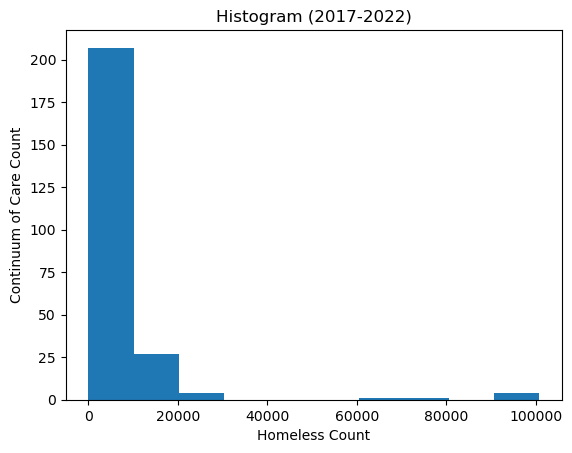

NormaltestResult(statistic=33.81549274344153, pvalue=4.540033415332651e-08)


In [20]:
# Characterize the data set using matplotlib and stats.normaltest
plt.hist(final_df['Homeless Count'])
plt.xlabel('Homeless Count')
plt.ylabel('Continuum of Care Count')
plt.title('Histogram (2017-2022)')

# Save the figure
plt.savefig("output_data/histogram.png", bbox_inches = "tight")

plt.show()
print(st.normaltest(final_df['Homeless Count'].sample(50)))

In [21]:
# Sort Homeless rate in descending order and show the top,10
homeless_rate_sort = final_df.sort_values(by='Homeless Rate',ascending=False)

In [22]:
# Filter for 2022 only
homeless_rate_2022 = homeless_rate_sort.loc[homeless_rate_sort['Year'] == 2022].iloc[:10]
homeless_rate_2022

,COC Name,Year,Total Population,Homeless Count,Homeless Rate,Unemployment Rate
231,San Francisco CoC,2022,837036,18833.0,2.249963,2.50
221,Merced County CoC,2022,284130,5469.0,1.924823,7.70
213,Humboldt County CoC,2022,134528,2572.0,1.911870,4.00
220,Mendocino County CoC,2022,89629,1628.0,1.816376,4.10
245,"Yuba, Sutter Counties CoC",2022,181283,2608.0,1.438635,6.05
208,Butte County CoC,2022,206582,2601.0,1.259064,4.50
232,San Joaquin County CoC,2022,782811,9505.0,1.214214,5.20
241,Stanislaus County CoC,2022,548719,6482.0,1.181297,5.40
214,Imperial County CoC,2022,178845,1857.0,1.038329,14.70
233,San Luis Obispo County CoC,2022,279751,2888.0,1.032347,3.00


In [23]:
pd.options.display.float_format = '{:,}'.format

# Sort Homeless count in descending order and show the top,10
homeless_count_sort = final_df.sort_values(by='Homeless Count',ascending=False)

In [24]:
# Filter for 2022 only
homeless_count_2022 = homeless_count_sort.loc[homeless_count_sort['Year'] == 2022].iloc[:10]
homeless_count_2022

,COC Name,Year,Total Population,Homeless Count,Homeless Rate,Unemployment Rate
218,Los Angeles County CoC,2022,9834503,"100,774.0",1.0246984519705773,4.9
230,San Diego County CoC,2022,3275435,"25,621.0",0.7822167131999261,3.4
225,Orange County CoC,2022,3151946,"23,225.0",0.7368463799823982,3.2
231,San Francisco CoC,2022,837036,"18,833.0",2.2499629645558854,2.5
236,Santa Clara County CoC,2022,1890967,"17,127.0",0.9057270698007951,2.6
228,Sacramento County CoC,2022,1573366,"11,728.0",0.7454082521167993,3.9
205,Alameda County CoC,2022,1644248,"11,628.0",0.707192588952518,3.3
229,San Bernardino County CoC,2022,2180777,"10,416.0",0.47762792802748744,4.1
227,Riverside County CoC,2022,2430976,"10,061.0",0.4138666938711036,4.2
232,San Joaquin County CoC,2022,782811,"9,505.0",1.2142139034837272,5.2


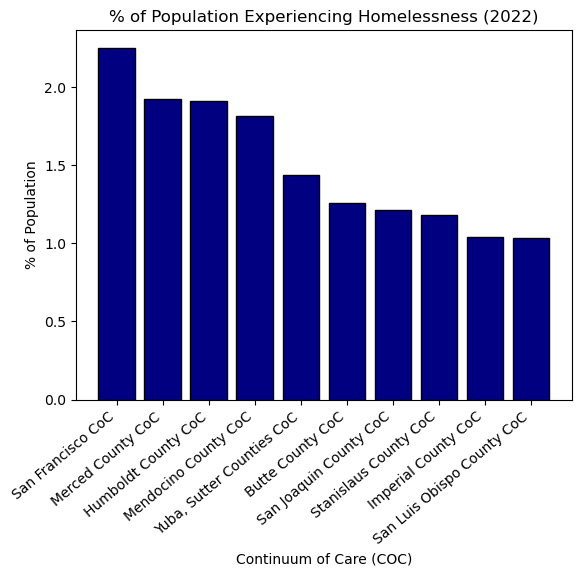

In [26]:
# Generate a bar plot showing the top 10 continuums of care by homeless rate
y_axis = homeless_rate_2022['Homeless Rate']
x_axis = homeless_rate_2022['COC Name']

ax = plt.bar(x_axis,y_axis, color='navy', edgecolor='black')

plt.xlabel("Continuum of Care (COC)")
plt.ylabel("% of Population")
plt.xticks(rotation=40, ha = 'right')
plt.title('% of Population Experiencing Homelessness (2022)')

# Save the figure
plt.savefig("output_data/percent_of_pop_bar.png", bbox_inches = "tight")

plt.show()

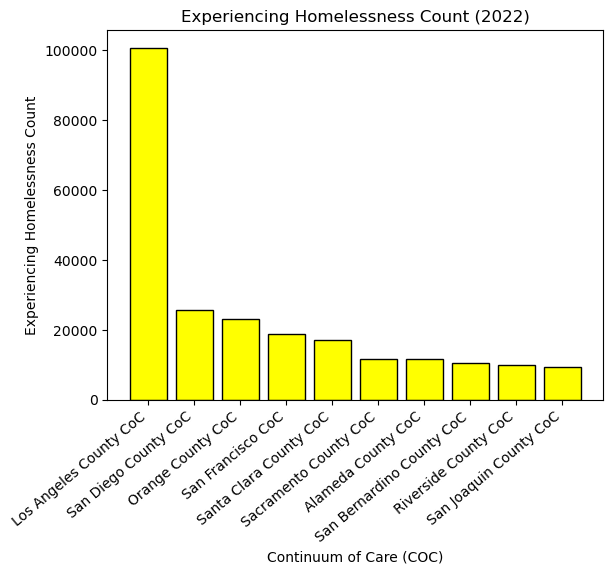

In [29]:
# Generate a bar plot showing the top 10 continuums of care by homeless count
x_axis = homeless_count_2022['COC Name']
y_axis = homeless_count_2022['Homeless Count']

ax = plt.bar(x_axis,y_axis,color='yellow', edgecolor='black')

plt.xlabel("Continuum of Care (COC)")
plt.ylabel("Experiencing Homelessness Count")
plt.xticks(rotation=40, ha = 'right')
plt.title('Experiencing Homelessness Count (2022)')

# Save the figure
plt.savefig("output_data/homeless_count_bar.png", bbox_inches = "tight")

plt.show()

C:\Users\mattcalvert\AppData\Local\anaconda3\envs\dev\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\mattcalvert\AppData\Local\anaconda3\envs\dev\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


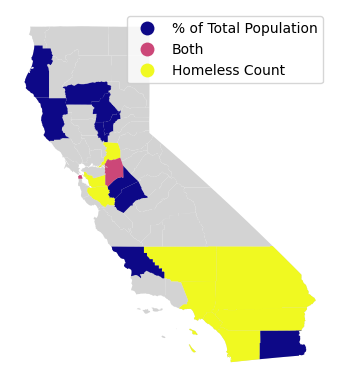

In [31]:
# Generate map
# Load the shapefile of California's counties
ca_counties = gpd.read_file('resources/california_counties.geojson')

homeless_rate_counties = ['Merced', 'Humboldt', 'Mendocino', "Yuba",
                          'Sutter', 'Butte', 'Stanislaus',
                          'Imperial', 'San Luis Obispo', 'Tehama']
homeless_count_counties = ['Los Angeles', 'San Diego', 'Orange', 'Santa Clara', 'Sacramento', 'Alameda', 
                           'San Bernardino', 'Riverside', 'Kern']
both = ['San Joaquin', 'San Francisco']

# Create a new column 'color' and set it to 'blue' for the specified counties
ca_counties['category'] = ''
ca_counties.loc[ca_counties['name'].isin(homeless_rate_counties), 'category'] = '% of Total Population'
ca_counties.loc[ca_counties['name'].isin(homeless_count_counties), 'category'] = 'Homeless Count'
ca_counties.loc[ca_counties['name'].isin(both), 'category'] = 'Both'

# Plot the map with the specified counties in blue
ax = ca_counties.plot(color='lightgrey')
ax.set_axis_off()
ca_counties = ca_counties.loc[(ca_counties['category'] == '% of Total Population') | 
                              (ca_counties['category'] == 'Homeless Count') |
                              (ca_counties['category'] == 'Both')]
ca_counties.plot(ax=ax, cmap = 'plasma', column='category', legend=True)

# Save the figure
plt.savefig("output_data/map.png", bbox_inches = "tight")


The correlation between homeless rate and unemployment rate is 0.03


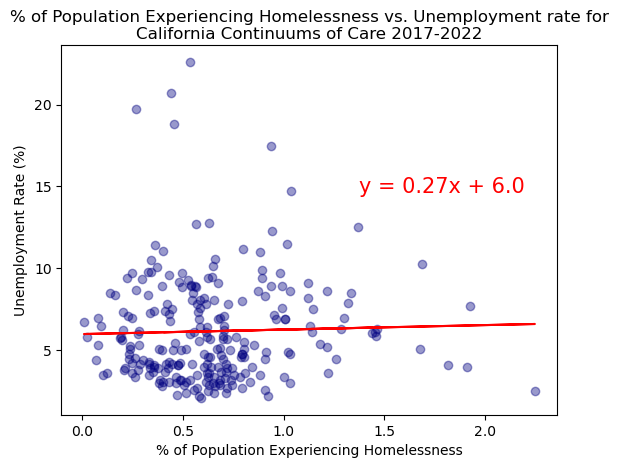

In [32]:
# Calculate the correlation coefficient and a linear regression model 
# for homeless rate and unemployment rate for all counties 2017-2022

x_axis=final_df['Homeless Rate']
y_axis=final_df['Unemployment Rate']

print(f"The correlation between homeless rate and unemployment rate is {round(st.pearsonr(x_axis,y_axis)[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_axis,y_axis, color = 'navy', alpha = 0.4)
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq, (0.60, .60), xycoords='axes fraction', fontsize=15,color='red')
plt.xlabel("% of Population Experiencing Homelessness")
plt.ylabel("Unemployment Rate (%)")
plt.title('% of Population Experiencing Homelessness vs. Unemployment rate for California Continuums of Care 2017-2022', wrap = True)

# Save the figure
plt.savefig("output_data/unemploment_correlation.png", bbox_inches = "tight")

plt.show()

#### Discussion about the linear relationship: The linear regression is modeling a very weak relationship between latitude and wind speed

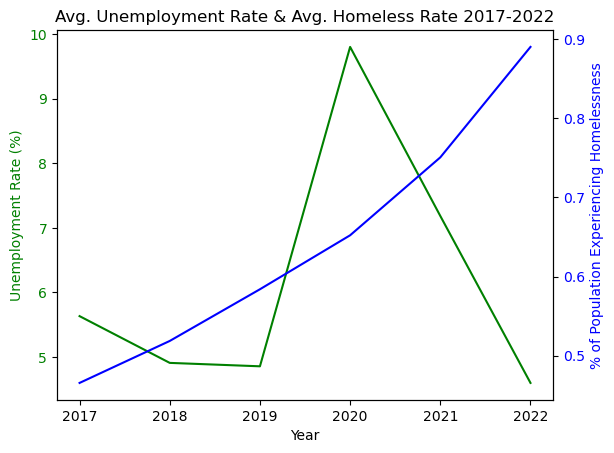

In [33]:
avg_unemployment_rate = final_df[['Year','Unemployment Rate','Homeless Rate']].groupby(['Year']).mean()

fig, ax1 = plt.subplots()

color = 'green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Unemployment Rate (%)', color=color)
ax1.plot(avg_unemployment_rate['Unemployment Rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('% of Population Experiencing Homelessness', color=color)
ax2.plot(avg_unemployment_rate['Homeless Rate'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Avg. Unemployment Rate & Avg. Homeless Rate 2017-2022')

# Save the figure
plt.savefig("output_data/line_chart.png", bbox_inches = "tight")

plt.show()